In [29]:
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import itertools
import statsmodels.api as sm
import warnings
from collections import defaultdict
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [30]:
# Directory where your images are stored
image_dir = 'dataset/downscaled/images'
mask_dir = 'dataset/downscaled/masks'

# List to store the images and masks
images = []
masks = []

# Load the images
for filename in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, filename))
    if img is not None:
        images.append(img)

# Load the masks
for filename in os.listdir(mask_dir):
    mask = cv2.imread(os.path.join(mask_dir, filename), cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        masks.append(mask)

2018 premonsoon: 321.3333333333333
2018 monsoon: 600.4545454545455
2018 postmonsoon: 455.655737704918
2018 winter: 517.7303370786517
2019 premonsoon: 380.44565217391306
2019 monsoon: 300.73770491803276
2019 postmonsoon: 311.49056603773585
2019 winter: 686.4736842105264
2020 premonsoon: 347.967032967033
2020 monsoon: 204.49180327868854
2020 postmonsoon: 259.4655172413793
2020 winter: 597.4166666666666


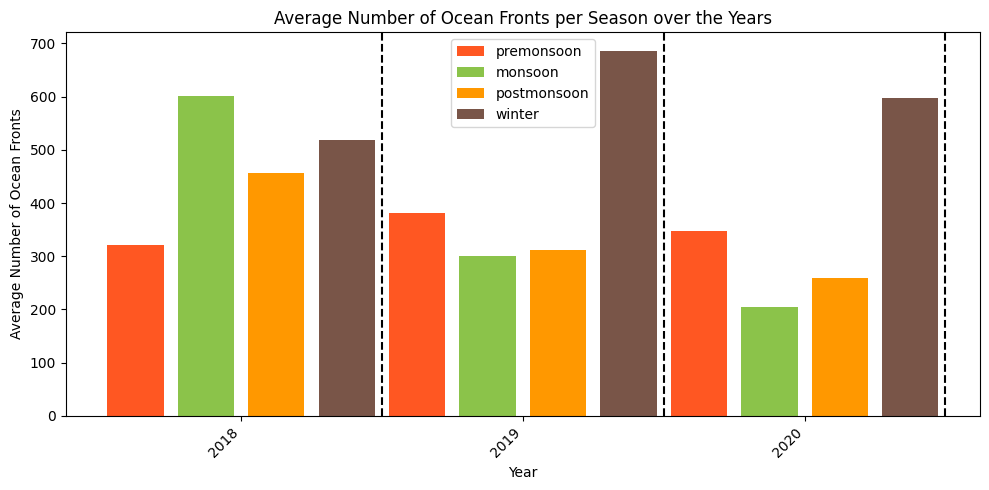

In [31]:


# Define the seasons
seasons = {'premonsoon': [3, 4, 5], 'monsoon': [6, 7, 8, 9], 'postmonsoon': [10, 11], 'winter': [12, 1, 2]}

# Map seasons to numbers for proper sorting
seasons_order = {'premonsoon': 1, 'monsoon': 2, 'postmonsoon': 3, 'winter': 4}

# Initialize a dictionary to hold the ocean front counts for each season and year
counts = defaultdict(list)

# Iterate over the masks
for filename in os.listdir(mask_dir):
    # Extract the year and month from the filename
    year = int(filename[:4])
    month = int(filename[4:6])
    
    # Determine the season based on the month
    for season, months in seasons.items():
        if month in months:
            # Load the mask
            mask = cv2.imread(os.path.join(mask_dir, filename), cv2.IMREAD_GRAYSCALE)
            
            # Count the number of ocean fronts (pixels with value 255)
            count = np.count_nonzero(mask == 255)
            
            # Store the count
            counts[(seasons_order[season], season, year)].append(count)

# Calculate the average count for each season and year
averages = {key: np.mean(value) for key, value in counts.items()}

# Sort the dictionary by year and season number
sorted_averages = dict(sorted(averages.items(), key=lambda item: (item[0][2], item[0][0])))

# Print the sorted ocean front counts
for (season_num, season, year), average in sorted_averages.items():
    print(f'{year} {season}: {average}')

# Plot the averages
plt.figure(figsize=(10, 5))

colors = {'premonsoon': '#FF5722', 'monsoon': '#8BC34A', 'postmonsoon': '#FF9800', 'winter': '#795548'}

x_ticks = []
x_tick_labels = []
for i, ((season_num, season, year), average) in enumerate(sorted_averages.items()):
    # Plot each bar with a label of year and season
    plt.bar(i, average, color=colors[season])
    
    if season == 'premonsoon':
        x_tick_labels.append(str(year))
        x_ticks.append(i+1.5)  # add 1.5 to position year label at the center of its group of bars

    if season == 'winter':
        plt.axvline(i+0.5, color='black', linestyle='--')  # add 0.5 to position line at the end of the group of bars

# Set the x-ticks to include the year once for each group of bars
plt.xticks(x_ticks, x_tick_labels, rotation=45, ha='right')

# Create a custom patch for each season to be displayed in the legend
legend_patches = [Patch(facecolor=color, label=season) for season, color in colors.items()]
plt.legend(handles=legend_patches)

plt.xlabel('Year')
plt.ylabel('Average Number of Ocean Fronts')
plt.title('Average Number of Ocean Fronts per Season over the Years')
plt.tight_layout()
plt.show()


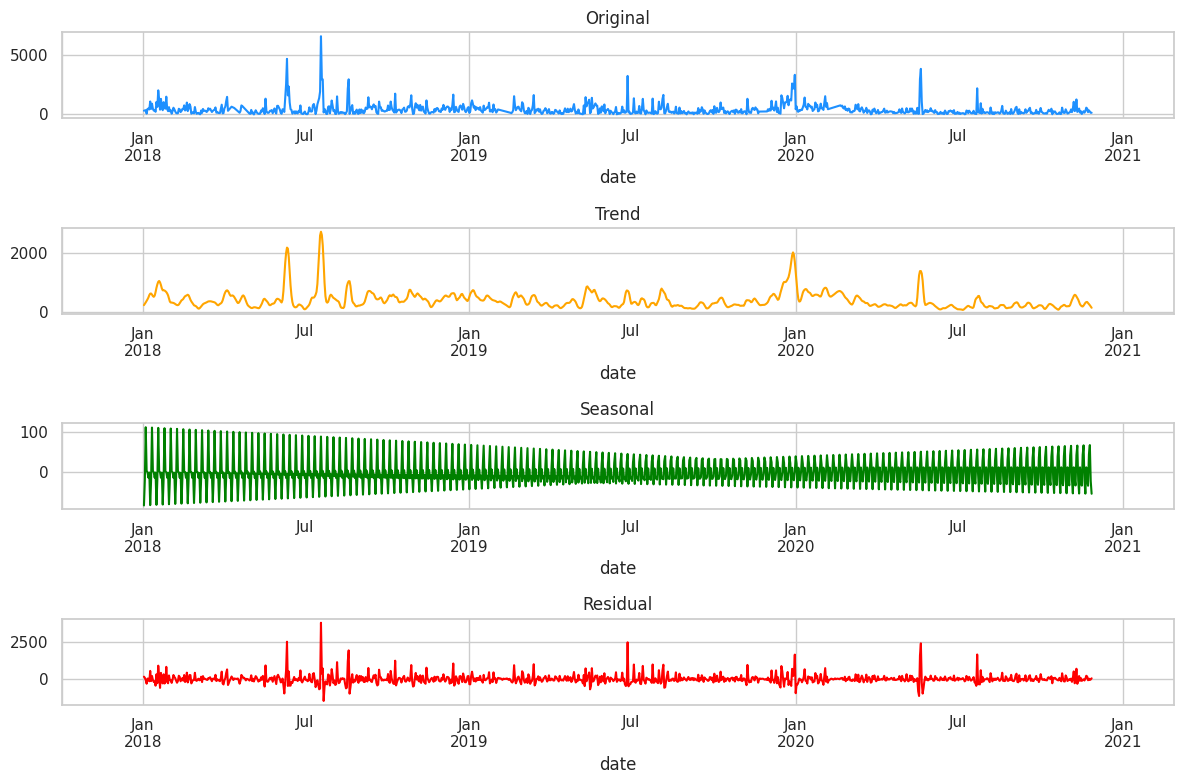

In [35]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from datetime import datetime
import seaborn as sns
from matplotlib.dates import DateFormatter

# Apply the seaborn style
sns.set(style="whitegrid")

image_dir = 'dataset/downscaled/images'
mask_dir = 'dataset/downscaled/masks'

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

data = []

for image_file, mask_file in zip(image_files, mask_files):
    mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        date = datetime.strptime(mask_file.split('.')[0], "%Y%m%d")
        ocean_pixels = np.sum(mask == 255)
        data.append([date, ocean_pixels])

df = pd.DataFrame(data, columns=['date', 'ocean_pixels'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df = df.resample('D').interpolate(method='linear')

stl = STL(df['ocean_pixels'], seasonal=365)
result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12, 8))

# Set a common date format for all subplots
date_format = DateFormatter("%Y")
for ax in axes:
    ax.xaxis.set_major_formatter(date_format)

# Expand x-limits
start_date = df.index.min() - pd.DateOffset(months=3)
end_date = df.index.max() + pd.DateOffset(months=3)

df['ocean_pixels'].plot(ax=axes[0], legend=False, title='Original', color='dodgerblue')
axes[0].set_xlim([start_date, end_date])
result.trend.plot(ax=axes[1], legend=False, title='Trend', color='orange')
axes[1].set_xlim([start_date, end_date])
result.seasonal.plot(ax=axes[2], legend=False, title='Seasonal', color='green')
axes[2].set_xlim([start_date, end_date])
result.resid.plot(ax=axes[3], legend=False, title='Residual', color='red')
axes[3].set_xlim([start_date, end_date])

plt.tight_layout()
plt.show()


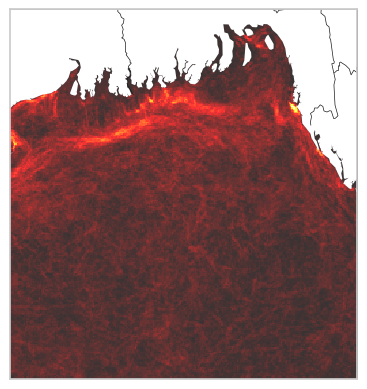

In [55]:
# Define the boundaries and create the basemap
min_lat = 17
max_lat = 23
min_lon = 87
max_lon = 93

map = Basemap(
    projection="merc",
    llcrnrlon=min_lon,
    llcrnrlat=min_lat,
    urcrnrlon=max_lon,
    urcrnrlat=max_lat,
    resolution="i",
)

# Fill the continents with white color
map.fillcontinents(color='white', lake_color='white')

# Sum up all the masks
sum_of_masks = np.sum(masks, axis=0)

# Normalize the result to create a heatmap
heatmap = sum_of_masks / np.max(sum_of_masks)

# Create a grid of latitude and longitude values
lon_vals = np.linspace(min_lon, max_lon, heatmap.shape[1])
lat_vals = np.linspace(min_lat, max_lat, heatmap.shape[0])
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

# Convert the latitude and longitude values to the projection of the basemap
x, y = map(lon_grid, lat_grid)

# Flip the heatmap vertically if necessary
heatmap = np.flipud(heatmap)

# Overlay the heatmap on the basemap using imshow
map.imshow(heatmap, cmap='hot', alpha=0.8, interpolation='nearest', extent=[min_lon, max_lon, min_lat, max_lat])

# Draw the coastlines and the countries
# map.drawcoastlines()
map.drawcountries()

# Show the plot
plt.show()
